# Natural Language Processing course
### Sentiment Analysis Towards Named Entities with Explainability Techniques
##### Julia Kaznowska, Patryk Rakus, Filip Szympliński, Michał Tomczyk

# Installations

In [ ]:
!pip install gcsfs==2024.10.0
!pip install fsspec==2024.10.0
!pip install datasets

  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [ ]:
!pip install transformers

In [ ]:
!pip install shapiq

# Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import transformers
from tqdm import tqdm
import string

from transformers import TFAutoModelForTokenClassification, TFBertModel, AutoTokenizer
from transformers import pipeline

from datasets import Dataset, DatasetDict

from google.colab import drive

# Bart seq-to-seq
from transformers import BartTokenizer, TFBartForConditionalGeneration, TFBertForMultipleChoice, BartForConditionalGeneration
from transformers import Trainer, TrainingArguments
import torch

# RoBERTa
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# XAI
import shapiq

# Datasets

## Named Entity Recognition

Firstly, let us load and process the MultiCoNER dataset used for training the Named Entity Recognition model.

In [ ]:
!pip install awscli --upgrade

In [ ]:
!aws s3 ls --no-sign-request s3://multiconer/multiconer2022/

                           PRE BN-Bangla/
                           PRE DE-German/
                           PRE EN-English/
                           PRE ES-Spanish/
                           PRE FA-Farsi/
                           PRE HI-Hindi/
                           PRE KO-Korean/
                           PRE MIX_Code_mixed/
                           PRE MULTI_Multilingual/
                           PRE NL-Dutch/
                           PRE RU-Russian/
                           PRE TR-Turkish/
                           PRE ZH-Chinese/


In [ ]:
!aws s3 cp --no-sign-request s3://multiconer/multiconer2022/EN-English/ ./multiconer2022/EN-English --recursive

download: s3://multiconer/multiconer2022/EN-English/en_dev.conll to multiconer2022/EN-English/en_dev.conll
download: s3://multiconer/multiconer2022/EN-English/en_train.conll to multiconer2022/EN-English/en_train.conll
download: s3://multiconer/multiconer2022/EN-English/en_test.conll to multiconer2022/EN-English/en_test.conll


In [ ]:
def parse_conll_file(filepath):
    sentences = []
    labels = []
    sentence = []
    label_seq = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split()
                word, _, _, label = parts
                if word == '#': # drop metadata
                    continue
                sentence.append(word)
                label_seq.append(label)
            else:
                if sentence:
                    sentences.append(sentence)
                    labels.append(label_seq)
                    sentence = []
                    label_seq = []
    if sentence:  # Add the last sentence if not followed by a newline
        sentences.append(sentence)
        labels.append(label_seq)
    return sentences, labels

X_train, y_train = parse_conll_file('./multiconer2022/EN-English/en_train.conll')
X_dev, y_dev = parse_conll_file('./multiconer2022/EN-English/en_dev.conll')
X_test, y_test = parse_conll_file('./multiconer2022/EN-English/en_test.conll')

In [ ]:
print(f"Train sentences count: {len(X_train)}")
print(f"Dev sentences count: {len(X_dev)}")
print(f"Test sentences count: {len(X_test)}")

Train sentences count: 15300
Dev sentences count: 800
Test sentences count: 217818


In [ ]:
print(f"Longest train sentence: {max([len(sentence) for sentence in X_train])}")
print(f"Longest dev sentence: {max([len(sentence) for sentence in X_dev])}")
print(f"Longest test sentence: {max([len(sentence) for sentence in X_test])}")

Longest train sentence: 41
Longest dev sentence: 39
Longest test sentence: 49


## Create tf dataset

In [ ]:
label_to_id = {
    'B-CORP': 0, 'B-CW': 1, 'B-GRP': 2, 'B-LOC': 3, 'B-PER': 4, 'B-PROD': 5,
    'I-CORP': 6, 'I-CW': 7, 'I-GRP': 8, 'I-LOC': 9, 'I-PER': 10, 'I-PROD': 11, 'O': 12
}
id_to_label = {v: k for k, v in label_to_id.items()}

In [ ]:
def tokenize_and_align_labels(examples, tokenizer, max_length=64):
    tokenized_inputs = tokenizer(examples["sentences"], truncation=True, padding="max_length", is_split_into_words=True, max_length=max_length)
    labels = []
    for i, label_seq in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(label_to_id[label_seq[word_idx]])
            else:
                aligned_labels.append(-100)  # Only label the first subtoken
            previous_word_idx = word_idx
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Load pre-trained tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convert data to Dataset objects
train_data = {"sentences": X_train, "labels": y_train}
dev_data = {"sentences": X_dev, "labels": y_dev}
test_data = {"sentences": X_test, "labels": y_test}

train_dataset = Dataset.from_dict(train_data)
dev_dataset = Dataset.from_dict(dev_data)
test_dataset = Dataset.from_dict(test_data)

# Tokenize and align labels
tokenized_train = train_dataset.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)
tokenized_dev = dev_dataset.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)
tokenized_test = test_dataset.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)

Map:   0%|          | 0/15300 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/217818 [00:00<?, ? examples/s]

In [ ]:
def to_tf_dataset(dataset, batch_size=16):
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": np.array(dataset["input_ids"]),
            "attention_mask": np.array(dataset["attention_mask"]),
            # "token_type_ids": np.array(dataset["token_type_ids"]),
        },
        np.array(dataset["labels"])
    )).batch(batch_size)


tf_train_dataset = to_tf_dataset(tokenized_train, batch_size=128)
tf_dev_dataset = to_tf_dataset(tokenized_dev, batch_size=32)
tf_test_dataset = to_tf_dataset(tokenized_test, batch_size=32)


## Sentiment dataset

Download train dataset from here:
http://metashare.ilsp.gr:8080/repository/browse/semeval-2014-absa-restaurant-reviews-train-data/479d18c0625011e38685842b2b6a04d72cb57ba6c07743b9879d1a04e72185b8/

Now let us load the SamEval-2014 ABSA dataset. We are going to modify it by extracting the entities with our NER model and replacing aspects in the original dataset with them, to obtain a dataset that can be used for NER and sentiment analysis at once.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xml.etree.ElementTree as ET

with open('/content/drive/MyDrive/Restaurants_Train.xml', 'r') as f:
    ABSA_train_data = f.read()

ABSA_test_data = !curl https://alt.qcri.org/semeval2014/task4/data/uploads/restaurants-trial.xml
ABSA_test_data = '\n'.join([row.strip() for row in ABSA_test_data])

root_train = ET.fromstring(ABSA_train_data)
root_test = ET.fromstring(ABSA_test_data)
absa_train_sentences = []

def extract_absa_sentences(root):
    absa_sentences = []
    for sentence in root.findall('sentence'):
        sentence_id = sentence.get('id')

        sentence_text = sentence.find('text').text
        aspect_categories = sentence.findall('.//aspectCategories/aspectCategory')
        aspect_terms = sentence.findall('.//aspectTerms/aspectTerm')

        absa_sentence = {
            'sentence_id': sentence_id,
            'sentence_text': sentence_text,
            'aspect_terms': [
                (term.get('term').lower(), term.get('polarity'), term.get('from'), term.get('to'))
                for term in aspect_terms
            ],
            'aspect_categories': [
                (category.get('category'), category.get('polarity'))
                for category in aspect_categories
            ]
        }

        absa_sentences.append(absa_sentence)
    return absa_sentences

absa_train_sentences = extract_absa_sentences(root_train)
absa_test_sentences = extract_absa_sentences(root_test)

In [ ]:
print(len(absa_test_sentences))
print(len(absa_train_sentences))

100
3044


In [ ]:
absa_all_sentences = absa_test_sentences + absa_train_sentences

In [ ]:
absa_test_sentences = absa_all_sentences[:int(0.2*len(absa_all_sentences))]

In [ ]:
absa_train_sentences = absa_all_sentences[int(0.2*len(absa_all_sentences)):]

In [ ]:
print(len(absa_test_sentences))
print(len(absa_train_sentences))

628
2516


In [ ]:
def extract_NE(X, y):
    named_entities = {
        "CORP": [], "CW": [], "GRP": [], "LOC": [], "PER": [], "PROD": []
    }
    for sentence, labels in tqdm(zip(X, y), total=len(X)):
        words = []
        category = None
        for word, label in zip(sentence, labels):
            if label[0] == 'B': # begin entity
                words = [word]
                category = label[2:]
            elif label[0] == 'I': # continue entity
                words.append(word)
            else: # no entity
                if words: #entity just ended
                    named_entities[category].append(' '.join(words))
                words = []
                category = None
    return named_entities

In [ ]:
train_entities = extract_NE(X_train, y_train)

100%|██████████| 15300/15300 [00:00<00:00, 306986.91it/s]


In [ ]:
all_terms = [term[0] for sentence in absa_train_sentences for term in sentence['aspect_terms']]
term_counts = pd.DataFrame(np.unique(all_terms, return_counts=True)).T.sort_values(by=1, ascending=False)
term_counts.columns = ['term', 'count']
term_counts.head(20)

,term,count
352,food,317
848,service,191
701,place,58
742,prices,55
917,staff,52
272,dinner,47
584,menu,46
699,pizza,41
38,atmosphere,37
737,price,36


In [ ]:
list(range(5, 1, -1))

[5, 4, 3, 2]

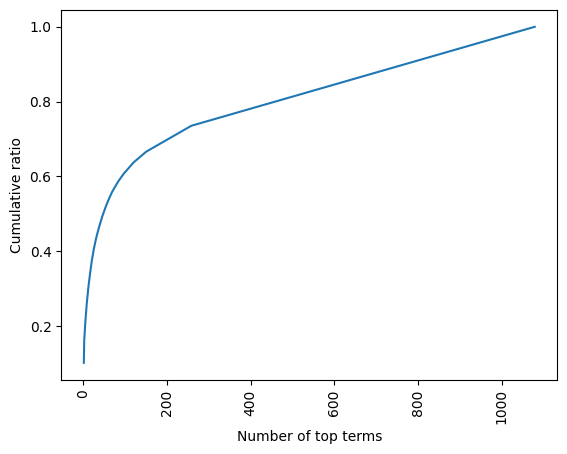

In [ ]:
category_counts_cumsum = term_counts['count'].cumsum()
category_counts_cumsum_ratio = category_counts_cumsum / term_counts['count'].sum()
sns.lineplot(x=range(1, len(term_counts)+1), y=category_counts_cumsum_ratio)
plt.xlabel('Number of top terms')
plt.ylabel('Cumulative ratio')
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_categories = [category[0] for sentence in absa_train_sentences for category in sentence['aspect_categories']]
pd.DataFrame(np.unique(all_categories, return_counts=True)).T.sort_values(by=1, ascending=False)

,0,1
2,food,1024
1,anecdotes/miscellaneous,936
4,service,490
0,ambience,369
3,price,269


In [ ]:
filtered_absa_train = [sentence for sentence in absa_train_sentences if sentence['aspect_terms']]
filtered_absa_test = [sentence for sentence in absa_test_sentences if sentence['aspect_terms']]

In [ ]:
def make_NE_sentiment(absa_sentences, random_state=42):
    result = {
        "sentence": [],
        "entity": [],
        "sentiment": [],
        "NER_labels": [],
    }
    np.random.seed(random_state)
    for sentence in tqdm(absa_sentences):
        polarities = []
        sentence_parts = []
        start_idx = 0
        for aspect in sentence['aspect_terms']:
            term_start = int(aspect[2])
            term_end = int(aspect[3])
            sentence_parts.append(sentence['sentence_text'][start_idx:term_start])
            start_idx = term_end
            polarities.append(aspect[1].upper())
        sentence_parts.append(sentence['sentence_text'][start_idx:])

        sentence = sentence_parts[0]
        entities = []
        NER_labels = ['O' for _ in sentence_parts[0].split()]
        for sentence_part in sentence_parts[1:]:
            cat = np.random.choice(['CORP', 'CW', 'GRP', 'LOC', 'PER', 'PROD'])
            entity = np.random.choice(train_entities[cat])
            entities.append(entity)
            NER_labels.append('B-' + cat) # add begin label
            NER_labels.extend([('I-' + cat)] * (len(entity.split()) - 1)) # add continuation tokens
            NER_labels.extend(['O'] * len(sentence_part.split()))
            if sentence_part == '': # two entities next to each other
                sentence_part = ' '
            sentence += entity + sentence_part

        result['sentence'].extend([sentence] * len(entities))
        result['entity'].extend(entities)
        result['sentiment'].extend(polarities)
        result['NER_labels'].extend([NER_labels] * len(entities))

    return result


In [ ]:
train_NE_sentiment = make_NE_sentiment(filtered_absa_train)
test_NE_sentiment = make_NE_sentiment(filtered_absa_test)

100%|██████████| 388/388 [00:00<00:00, 700.68it/s]


In [ ]:
nes_train = pd.DataFrame(train_NE_sentiment)
nes_test = pd.DataFrame(test_NE_sentiment)

In [ ]:
for row in nes_train.head(11).iterrows():
    print(row[1]['sentence'])
    print(row[1]['entity'])
    print(row[1]['sentiment'])
    print(row[1]['NER_labels'])

I found the sisian to be outstanding, particulary the the rolling stones I had.
sisian
POSITIVE
['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-GRP', 'I-GRP', 'I-GRP', 'O', 'O']
I found the sisian to be outstanding, particulary the the rolling stones I had.
the rolling stones
POSITIVE
['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-GRP', 'I-GRP', 'I-GRP', 'O', 'O']
Mizu is home to creative and unique george cholmondeley, 1st marquess of cholmondeley not to found anywhere else.
george cholmondeley, 1st marquess of cholmondeley
POSITIVE
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
Baluchi's has solid prequel and a nice db regio at reasonable valerie singleton.
prequel
POSITIVE
['O', 'O', 'O', 'B-CW', 'O', 'O', 'O', 'B-GRP', 'I-GRP', 'O', 'O', 'B-PER', 'I-PER', 'O']
Baluchi's has solid prequel and a nice db regio at reasonable valerie singleton.
db regio
POSITIVE
['O', 'O', 'O', 'B-CW', 'O', 'O', 'O', 'B-GRP',

An insight into our processed dataset: first 100 sentences with entites in the place of aspects:

In [ ]:
for sentence in nes_test['sentence'].unique()[:100]:
    print(sentence)

All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
And really large db regio.
The valerie singleton was excellent as was the the times and the robert ryan but the bulgaria was forgettable.
vero beach was quick.
Oh, don't even let me start with how expensive the warmian-masurian voivodeship were!
ribollita is top notch.
The best thing I tasted were the boston.
Even though its good oricon, the stockport county f.c. are too high.
In addition, the diary is very good and the auckland are reasonable.
The lgoc x-type is great and authentic.
I recommend the ski, catonsville, and anything with startup company.
The fred frith was impressive with selections ranging from a gotta be somebody, to national football league, to hackamore.
very good top gear as well.
Anyway, the the monster squad is good, the all or nothing at all is right and they have a decent lublin.
The france was lousy -too s

In [ ]:
nes_test['sentiment'].unique()

array(['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'CONFLICT'], dtype=object)

# Bart seq2seq attempt

We have attempted predicting sentiments towards entities by using the sequence-to-sequence BART model, by trying to fine-tune it on queries asking about sentiments towards entities in sentences.

In [ ]:
# Load pre-trained BART model and tokenizer for sequence-to-sequence tasks
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
model = TFBartForConditionalGeneration.from_pretrained("facebook/bart-large")

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [ ]:
nes_train_testing = nes_train.copy()

In [ ]:
nes_train_testing['question'] = nes_train_testing.apply(lambda x: f"What is the sentiment towards {x['entity']}?", axis=1)

In [ ]:
nes_train_testing['context'] = nes_train_testing['sentence']
nes_train_testing['answer'] = nes_train_testing['sentiment']
nes_train_testing = nes_train_testing.drop(columns=['sentence', 'entity', 'sentiment', 'NER_labels'])

In [ ]:
# Convert the data to a Huggingface Dataset
dataset = Dataset.from_dict(nes_train_testing.to_dict('list'))

In [ ]:
nes_train_testing['question'].apply(lambda x: len(x)).max()

100

In [ ]:
def preprocess_function(examples):
    inputs = tokenizer(examples['question'], examples['context'], truncation=True, padding="max_length", max_length=256)
    labels = tokenizer(examples['answer'], truncation=True, padding=True, max_length=16)

    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=500,
    report_to=["none"],
    lr_scheduler_type="linear",
    learning_rate=1e-7,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
)

trainer.train()


Step,Training Loss
10,0.276500
20,0.259100
30,0.351000
40,0.231900
50,0.270400
60,0.261200
70,0.289900
80,0.219800
90,0.213400
100,0.270900


KeyboardInterrupt: 

In [ ]:
def generate_sentiment_prediction(question, context):
    input_text = f"question: {question} context: {context}"

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).to(model.device)

    summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)

    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return answer

context_sentence = nes_train_testing['context'].iloc[2]
question = nes_train_testing['question'].iloc[2]

predicted_sentiment = generate_sentiment_prediction(question, context_sentence)

print(context_sentence)
print(question)
print(f"Predicted Sentiment: {predicted_sentiment}")

Mizu is home to creative and unique george cholmondeley, 1st marquess of cholmondeley not to found anywhere else.
What is the sentiment towards george cholmondeley, 1st marquess of cholmondeley?
Predicted Sentiment: POSITIVE


In [ ]:
correct_count = 0

for row in nes_train_testing.head(100).iterrows():
    question = row[1]['question']
    context_sentence = row[1]['context']
    print(row[1]['context'])
    print(row[1]['question'])
    predicted_sentiment = generate_sentiment_prediction(question, context_sentence)
    print(f"Predicted Sentiment: {predicted_sentiment} Actual: {row[1]['answer']}")
    print('\n')

    if predicted_sentiment == row[1]['answer']:
        correct_count += 1

accuracy = correct_count / len(nes_train_testing.head(100))
print(f"Accuracy: {accuracy * 100:.2f}%")

I found the sisian to be outstanding, particulary the the rolling stones I had.
What is the sentiment towards sisian?
Predicted Sentiment: POSITIVE Actual: POSITIVE


I found the sisian to be outstanding, particulary the the rolling stones I had.
What is the sentiment towards the rolling stones?
Predicted Sentiment: NEUTRAL Actual: POSITIVE


Mizu is home to creative and unique george cholmondeley, 1st marquess of cholmondeley not to found anywhere else.
What is the sentiment towards george cholmondeley, 1st marquess of cholmondeley?
Predicted Sentiment: NEUTRAL Actual: POSITIVE


Baluchi's has solid prequel and a nice db regio at reasonable valerie singleton.
What is the sentiment towards prequel?
Predicted Sentiment: POSITIVE Actual: POSITIVE


Baluchi's has solid prequel and a nice db regio at reasonable valerie singleton.
What is the sentiment towards db regio?
Predicted Sentiment: POSITIVE Actual: POSITIVE


Baluchi's has solid prequel and a nice db regio at reasonable valerie sin

Unfortunately the model failed to produce successful results, sometimes even not providing actual words in predictions.

# RoBERTa test for sentiment

Another attempt was to train a version of the BERT model, where the input would be the whole sentence, with a clearly highlighted entity at the end (preceded by a separator).

In [ ]:
MODEL_NAME = 'roberta-base'

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentiment_mapping = {'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1, 'CONFLICT': 3}

In [ ]:
nes_train['sentiment_mapped'] = nes_train['sentiment'].apply(lambda x: sentiment_mapping.get(x, 1))

In [ ]:
nes_test['sentiment_mapped'] = nes_test['sentiment'].apply(lambda x: sentiment_mapping.get(x, 1))

In [ ]:
def encode_text(df):
  input_text = f'{df["sentence"]} [SEP] {df["entity"]} [SEP]'
  encoding = tokenizer(input_text,  padding="max_length", truncation=True, max_length=128)
  encoding["label"] = int(df["sentiment_mapped"])
  return encoding

In [ ]:
train_nes_df = Dataset.from_pandas(nes_train.drop(columns=['NER_labels', 'sentiment'])).map(encode_text)

Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

In [ ]:
test_nes_df = Dataset.from_pandas(nes_test.drop(columns=['NER_labels', 'sentiment'])).map(encode_text)

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

In [ ]:
!mkdir -p /content/drive/MyDrive/RoBERTa_model

In [ ]:
!mkdir -p /content/drive/MyDrive/RoBERTa_model/results

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/RoBERTa_model/results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.001,
    report_to="none",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_nes_df,
    eval_dataset=test_nes_df,
    tokenizer=tokenizer)

<ipython-input-72-25636fa800f0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.713883
2,0.808100,0.566940
3,0.549700,0.624706
4,0.414400,0.630874
5,0.414400,0.656560


TrainOutput(global_step=1940, training_loss=0.5315851349191567, metrics={'train_runtime': 535.7832, 'train_samples_per_second': 28.967, 'train_steps_per_second': 3.621, 'total_flos': 1020889226772480.0, 'train_loss': 0.5315851349191567, 'epoch': 5.0})

In [ ]:
model.save_pretrained("/content/drive/MyDrive/RoBERTa_model/model")

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/RoBERTa_model/tokenizer")

('/content/drive/MyDrive/RoBERTa_model/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/RoBERTa_model/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/RoBERTa_model/tokenizer/vocab.json',
 '/content/drive/MyDrive/RoBERTa_model/tokenizer/merges.txt',
 '/content/drive/MyDrive/RoBERTa_model/tokenizer/added_tokens.json')

Unfortunately, the model suffers from overfitting and does not produce satisfactory results.

# NER Model

Final version of the NER model, using DistilBERT, which was adidtionally pre-trained on our data

In [ ]:
print("Devices available:", tf.config.list_physical_devices())

Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    """
    Custom loss function to ignore tokens with label -100.
    """
    mask = tf.not_equal(y_true, -100)
    # Replace -100 with 0 for loss calculation
    y_true = tf.where(mask, y_true, 0)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss = tf.where(mask, loss, 0)
    return tf.reduce_sum(loss) / tf.reduce_sum(tf.cast(mask, tf.float32))


def masked_accuracy(y_true, y_pred):
    """
    Custom accuracy metric that ignores tokens with label -100 and, optionally, padding tokens.
    """
    label_mask = tf.not_equal(y_true, -100)
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    matches = tf.equal(tf.cast(y_true, tf.int64), tf.cast(y_pred_classes, tf.int64))
    matches = tf.logical_and(matches, label_mask)

    valid_tokens = tf.reduce_sum(tf.cast(label_mask, tf.float32))
    accuracy = tf.reduce_sum(tf.cast(matches, tf.float32)) / (valid_tokens + 1e-8)  # Avoid division by zero

    return accuracy


In [ ]:
def create_model(bert_model, max_len = 64, num_labels=13):
    input_ids = tf.keras.Input(shape=(max_len,), dtype = 'int32', name='input_ids')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype = 'int32', name='attention_mask')
    bert_model.bert.pooler.trainable = False
    bert_output = bert_model(input_ids, attention_mask=attention_masks, return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    x = tf.keras.layers.Dense(64, activation='relu')(embedding)
    x = tf.keras.layers.BatchNormalization()(x)
    output = tf.keras.layers.Dense(num_labels, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), loss=masked_sparse_categorical_crossentropy, metrics=[masked_accuracy])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', num_labels=13)

    model = create_model(bert_model, num_labels=13)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
history_ner = model.fit(tf_train_dataset, validation_data=tf_dev_dataset, epochs=20)

Epoch 1/20
120/120 [==============================] - 107s 609ms/step - loss: 1.2434 - masked_accuracy: 0.6711 - val_loss: 0.5997 - val_masked_accuracy: 0.8414
Epoch 2/20
120/120 [==============================] - 68s 569ms/step - loss: 0.5165 - masked_accuracy: 0.8543 - val_loss: 0.3531 - val_masked_accuracy: 0.9018
Epoch 3/20
120/120 [==============================] - 68s 569ms/step - loss: 0.3359 - masked_accuracy: 0.9040 - val_loss: 0.2473 - val_masked_accuracy: 0.9283
Epoch 4/20
120/120 [==============================] - 68s 569ms/step - loss: 0.2489 - masked_accuracy: 0.9269 - val_loss: 0.2089 - val_masked_accuracy: 0.9394
Epoch 5/20
120/120 [==============================] - 68s 570ms/step - loss: 0.2075 - masked_accuracy: 0.9385 - val_loss: 0.1883 - val_masked_accuracy: 0.9447
Epoch 6/20
120/120 [==============================] - 68s 569ms/step - loss: 0.1826 - masked_accuracy: 0.9449 - val_loss: 0.1769 - val_masked_accuracy: 0.9501
Epoch 7/20
120/120 [=========================

In [ ]:
def ne_recognition(model, sentence):
  tokenized_inputs = tokenizer(
    sentence.split(),
    truncation=True,
    padding="max_length",
    is_split_into_words=True,
    max_length=64,
    return_tensors="tf"
  )

  label_to_id = {
    'B-CORP': 0, 'B-CW': 1, 'B-GRP': 2, 'B-LOC': 3, 'B-PER': 4, 'B-PROD': 5,
    'I-CORP': 6, 'I-CW': 7, 'I-GRP': 8, 'I-LOC': 9, 'I-PER': 10, 'I-PROD': 11, 'O': 12
  }
  id_to_label = {v: k for k, v in label_to_id.items()}

  if "token_type_ids" in tokenized_inputs:
    del tokenized_inputs["token_type_ids"]
  inputs = {key: np.array(value) for key, value in tokenized_inputs.items()}

  y_pred = model.predict(inputs, verbose=0)
  y_pred_classes = tf.argmax(y_pred, axis=-1).numpy()[0]

  word_ids = tokenized_inputs.word_ids(batch_index=0)

  predicted_labels = []
  current_word = None
  for idx, word_id in enumerate(word_ids):
      if word_id is None:  # Special tokens like [CLS], [SEP], or padding
          continue
      if word_id != current_word:  # First subtoken of a word
          predicted_labels.append(id_to_label[y_pred_classes[idx]])
          current_word = word_id

  return predicted_labels

def print_labels(sentence, predicted_labels):
  print("Original Sentence:", sentence)
  print("Words:", sentence.split())
  print("Predicted Labels:", predicted_labels)
  for word, label in zip(sentence.split(), predicted_labels):
      print(f'({word} = {label})')

In [ ]:
sentence = "I love steve jobs, but when he created the iphone 15 was the worst phone ever"

predicted_labels = ne_recognition(model, sentence)
print_labels(sentence, predicted_labels)

Original Sentence: I love steve jobs, but when he created the iphone 15 was the worst phone ever
Words: ['I', 'love', 'steve', 'jobs,', 'but', 'when', 'he', 'created', 'the', 'iphone', '15', 'was', 'the', 'worst', 'phone', 'ever']
Predicted Labels: ['O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-PROD', 'I-PROD', 'O', 'O', 'O', 'O', 'O']
(I = O)
(love = O)
(steve = B-PER)
(jobs, = I-PER)
(but = O)
(when = O)
(he = O)
(created = O)
(the = O)
(iphone = B-PROD)
(15 = I-PROD)
(was = O)
(the = O)
(worst = O)
(phone = O)
(ever = O)


In [ ]:
# Save the model
model_weights_path = "./NER_BERT_weights_09_12_2024/saved_weights"
model.save_weights(model_weights_path)

# Save the tokenizer
tokenizer_save_path = "./tokenizer_NER_09_12_2024"
tokenizer.save_pretrained(tokenizer_save_path)

('./tokenizer_NER_09_12_2024/tokenizer_config.json',
 './tokenizer_NER_09_12_2024/special_tokens_map.json',
 './tokenizer_NER_09_12_2024/vocab.txt',
 './tokenizer_NER_09_12_2024/added_tokens.json',
 './tokenizer_NER_09_12_2024/tokenizer.json')

In [ ]:
# drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/NER_model
!cp -r ./NER_BERT_weights_09_12_2024 /content/drive/MyDrive/NER_model
!cp -r ./tokenizer_NER_09_12_2024 /content/drive/MyDrive/NER_model

# Sentiment model

Final version of the sentiment classification model is trained here. It is also a version of the DistilBERT model.

In [ ]:
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
revision = "714eb0f"
SENTIMENT_ANALYZER = pipeline("sentiment-analysis", verbose=0)


def entities_positions(sentence, predicted_labels):
  entities = []
  positions = []
  entity = None
  entity_label = None
  for i, (word, label) in enumerate(zip(sentence.split(), predicted_labels)):
      if label.startswith('B'):
          entity = word
          position = i
      elif label.startswith('I'):
          entity = entity + ' ' + word
      elif entity is not None:
          entities.append(entity)
          positions.append(position)
          entity = None
  if entity:
      entities.append(entity)
      positions.append(position)

  return entities, positions


def get_context(entities, positions):
  sentiment_inputs = []
  for entity, position in zip(entities, positions):
      split_sentence = np.array(sentence.split())
      context = ' '.join(split_sentence[max(0, position - 5):min(len(split_sentence), position + 5)])
      sentiment_inputs.append(f"Entity: {entity}. Context: {context}")

  return sentiment_inputs


def predict_sentiment(sentiment_inputs):
  # Perform sentiment analysis
  entity_sentiments = []
  for sentiment_input in sentiment_inputs:
      sentiment_result = SENTIMENT_ANALYZER(sentiment_input, verbose=0)
      entity_sentiments.append(sentiment_result[0])

  # Combine entities with their sentiment
  entity_sentiments_combined = [
      {"entity": entity, "sentiment": sentiment}
      for entity, sentiment in zip(entities, entity_sentiments)
  ]

  return entity_sentiments_combined

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


## Sentiment tests

Here, both components of the solution were tested on the ABSA dataset processed by us.

In [ ]:
path = '/content/drive/MyDrive'

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', num_labels=13)

    model = create_model(bert_model, num_labels=13)

# Load the saved weights
model_weights_path = f"{path}/NER_model/NER_BERT_weights_09_12_2024/saved_weights"
model.load_weights(model_weights_path)

# Load the tokenizer
tokenizer_save_path = f"{path}/NER_model/tokenizer_NER_09_12_2024"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

print("Model and tokenizer successfully loaded!")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model and tokenizer successfully loaded!


In [ ]:
entity_sentiment

{'entity': 'lgoc x-type',
 'sentiment': {'label': 'POSITIVE', 'score': 0.9996433258056641}}

In [ ]:
nes_test_orig = nes_test.copy()

In [ ]:
nes_train_NER = nes_train.drop_duplicates(subset=['sentence'])
nes_train_NER['sentence'] = nes_train_NER['sentence'].apply(lambda x: x.split())

<ipython-input-183-0daef4187e01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nes_train_NER['sentence'] = nes_train_NER['sentence'].apply(lambda x: x.split())


In [ ]:
nes_train_dict = nes_train_NER[:-100][nes_train_NER[:-100]['sentiment'].isin(['POSITIVE', 'NEGATIVE'])].to_dict('list')
nes_val_dict = nes_train_NER[-100:][nes_train_NER[-100:]['sentiment'].isin(['POSITIVE', 'NEGATIVE'])].to_dict('list')

In [ ]:
# Convert data to Dataset objects
nes_train_data = {"sentences": nes_train_dict['sentence'], "labels": nes_train_dict['NER_labels']}
nes_val_data = {"sentences": nes_val_dict['sentence'], "labels": nes_val_dict['NER_labels']}

nes_train_dataset = Dataset.from_dict(nes_train_data)
nes_val_dataset = Dataset.from_dict(nes_val_data)

# Tokenize and align labels
tokenized_nes_train = nes_train_dataset.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)
tokenized_nes_val = nes_val_dataset.map(lambda x: tokenize_and_align_labels(x, tokenizer), batched=True)

tf_nes_train_dataset = to_tf_dataset(tokenized_nes_train, batch_size=128)
tf_nes_val_dataset = to_tf_dataset(tokenized_nes_val, batch_size=16)

Map:   0%|          | 0/1329 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

In [ ]:
history_nes = model.fit(tf_nes_train_dataset, validation_data=tf_nes_val_dataset, epochs=10)

Epoch 1/10
11/11 [==============================] - 6s 562ms/step - loss: 0.6223 - masked_accuracy: 0.8673 - val_loss: 0.3721 - val_masked_accuracy: 0.9038
Epoch 2/10
11/11 [==============================] - 6s 559ms/step - loss: 0.4422 - masked_accuracy: 0.8856 - val_loss: 0.3102 - val_masked_accuracy: 0.9151
Epoch 3/10
11/11 [==============================] - 6s 557ms/step - loss: 0.3874 - masked_accuracy: 0.8979 - val_loss: 0.2876 - val_masked_accuracy: 0.9241
Epoch 4/10
11/11 [==============================] - 6s 556ms/step - loss: 0.3460 - masked_accuracy: 0.9117 - val_loss: 0.2719 - val_masked_accuracy: 0.9249
Epoch 5/10
11/11 [==============================] - 6s 554ms/step - loss: 0.3218 - masked_accuracy: 0.9162 - val_loss: 0.2619 - val_masked_accuracy: 0.9291
Epoch 6/10
11/11 [==============================] - 6s 554ms/step - loss: 0.3004 - masked_accuracy: 0.9213 - val_loss: 0.2524 - val_masked_accuracy: 0.9313
Epoch 7/10
11/11 [==============================] - 6s 553ms/ste

In [ ]:
with strategy.scope():
    # smaller LR
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=masked_sparse_categorical_crossentropy, metrics=[masked_accuracy])

history_nes = model.fit(tf_nes_train_dataset, validation_data=tf_nes_val_dataset, epochs=20)

Epoch 1/20
11/11 [==============================] - 46s 863ms/step - loss: 0.2354 - masked_accuracy: 0.9362 - val_loss: 0.2398 - val_masked_accuracy: 0.9372
Epoch 2/20
11/11 [==============================] - 6s 550ms/step - loss: 0.2280 - masked_accuracy: 0.9389 - val_loss: 0.2393 - val_masked_accuracy: 0.9380
Epoch 3/20
11/11 [==============================] - 6s 553ms/step - loss: 0.2295 - masked_accuracy: 0.9375 - val_loss: 0.2388 - val_masked_accuracy: 0.9387
Epoch 4/20
11/11 [==============================] - 6s 555ms/step - loss: 0.2250 - masked_accuracy: 0.9389 - val_loss: 0.2379 - val_masked_accuracy: 0.9401
Epoch 5/20
11/11 [==============================] - 6s 557ms/step - loss: 0.2218 - masked_accuracy: 0.9403 - val_loss: 0.2372 - val_masked_accuracy: 0.9396
Epoch 6/20
11/11 [==============================] - 6s 558ms/step - loss: 0.2206 - masked_accuracy: 0.9414 - val_loss: 0.2369 - val_masked_accuracy: 0.9396
Epoch 7/20
11/11 [==============================] - 6s 556ms/st

In [ ]:
np.array([1, 2, 3])[np.array([False, False,  True])]

array([3])

Iterative testing through each sentence to obtain complete results

In [ ]:
nes_test = nes_test_orig.copy()
# nes_test = nes_test[nes_test['sentiment'].isin(['POSITIVE', 'NEGATIVE'])]

test_sentences = list(nes_test['sentence'].unique())

count_all = 0
count_correct = 0
entity_correct = 0
sentiment_correct = 0
sentiment_all = 0

entire_count = 0
entire_correct = 0

entity_count = 0
entity_correct = 0

sentiment_count = 0
sentiment_correct = 0

failures = 0
wrong_preds = []
wrong_ents = []
correct_preds = []
correct_ents = []

for sentence in tqdm(test_sentences):
    try:
        actual_entities = nes_test[nes_test['sentence'] == sentence]['entity'].to_list()
        actual_polarities = nes_test[nes_test['sentence'] == sentence]['sentiment'].to_list()
        entity_polarity = {entity: polarity for entity, polarity in zip(actual_entities, actual_polarities)}
        entity_count += len(entity_polarity)

        predicted_labels = ne_recognition(model, sentence)
        entities, positions = entities_positions(sentence, predicted_labels)
        sentiment_inputs = get_context(entities, positions)
        entity_sentiments_combined = predict_sentiment(sentiment_inputs)

        for entity_sentiment in entity_sentiments_combined:
            entity = entity_sentiment['entity'].strip(string.punctuation)
            if entity in entity_polarity:
                correct_ents.append((sentence, entity, actual_entities))
                entity_correct += 1
                if entity_polarity[entity] not in ("POSITIVE", "NEGATIVE"): # ignore for sentiment and entire
                    continue

                entire_count += 1
                sentiment_count += 1
                if entity_sentiment['sentiment']['label'] == entity_polarity[entity]:
                    entire_correct += 1
                    sentiment_correct += 1
                    correct_preds.append((sentence, entity, entity_sentiment['sentiment']['label'], entity_polarity[entity]))
                else: # wrong sentiment predicted
                    wrong_preds.append((sentence, entity, entity_sentiment['sentiment']['label'], entity_polarity[entity]))
            else: # didnt detect entity
                wrong_ents.append((sentence, entity, actual_entities))
                entire_count +=1
    except Exception as e:
        failures += 1 # due to entities being incorreclty labeled (e.g. I-GRP after B-PROD)
        continue


print('\n')
accuracy = entire_correct / entire_count
sentiment_accuracy = sentiment_correct / sentiment_count
entity_accuracy = entity_correct / entity_count
print(accuracy)
print(sentiment_accuracy)
print(entity_accuracy)
print(failures)

100%|██████████| 388/388 [01:03<00:00,  6.12it/s]



0.6841004184100419
0.7917675544794189
0.7163531114327062
29


In [ ]:
for row in wrong_ents:
    print("Sentence: ", row[0])
    print("Entity: ", row[1])
    print("Actual entities: ", row[2])
    print('\n')

Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  rolling stones
Actual entities:  ['sisian', 'the rolling stones', 'george cholmondeley, 1st marquess of cholmondeley', 'prequel']


Sentence:  Even though its good oricon, the stockport county f.c. are too high.
Entity:  stockport county f.c
Actual entities:  ['oricon', 'stockport county f.c.']


Sentence:  The the borrowers now is inconsistent.
Entity:  the borrowers now
Actual entities:  ['the borrowers']


Sentence:  The ceramic rule.
Entity:  ceramic rule
Actual entities:  ['ceramic']


Sentence:  The pittsburgh pirates offered were unique, very tasty and fresh from the ipad pro, hearst castle, adana demirspor to the amazing dutch west india company (the best and freshest I've ever had).
Entity:  demirspor
Actual entities:  ['pittsburgh pirates', 'ipad pro', 'hearst castle', 'adana demirspor', 'dutch west 

In [ ]:
for row in correct_ents:
    print("Sentence: ", row[0])
    print("Entity: ", row[1])
    print("Actual entities: ", row[2])
    print('\n')

Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  sisian
Actual entities:  ['sisian', 'the rolling stones', 'george cholmondeley, 1st marquess of cholmondeley', 'prequel']


Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  george cholmondeley, 1st marquess of cholmondeley
Actual entities:  ['sisian', 'the rolling stones', 'george cholmondeley, 1st marquess of cholmondeley', 'prequel']


Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  prequel
Actual entities:  ['sisian', 'the rolling stones', 'george cholmondeley, 1st marquess of cholmondeley', 'prequel']


Sentence:  And really large db regio.
Entity:  

In [ ]:
for row in wrong_preds:
    print("Sentence: ", row[0])
    print("Entity: ", row[1])
    print("Predicted sentiment: ", row[2])
    print("Actual sentiment: ", row[3])
    print('\n')

Sentence:  And really large db regio.
Entity:  db regio
Predicted sentiment:  NEGATIVE
Actual sentiment:  POSITIVE


Sentence:  vero beach was quick.
Entity:  vero beach
Predicted sentiment:  NEGATIVE
Actual sentiment:  POSITIVE


Sentence:  Even though its good oricon, the stockport county f.c. are too high.
Entity:  oricon
Predicted sentiment:  NEGATIVE
Actual sentiment:  POSITIVE


Sentence:  Anyway, the the monster squad is good, the all or nothing at all is right and they have a decent lublin.
Entity:  all or nothing at all
Predicted sentiment:  NEGATIVE
Actual sentiment:  POSITIVE


Sentence:  And the the tree of knowledge was pathetic.
Entity:  the tree of knowledge
Predicted sentiment:  POSITIVE
Actual sentiment:  NEGATIVE


Sentence:  Try the pizza, it is to die for.
Entity:  pizza
Predicted sentiment:  NEGATIVE
Actual sentiment:  POSITIVE


Sentence:  The waste is great and reasonably guitar center.
Entity:  waste
Predicted sentiment:  NEGATIVE
Actual sentiment:  POSITIVE


S

In [ ]:
for row in correct_preds:
    print("Sentence: ", row[0])
    print("Entity: ", row[1])
    print("Actual entities: ", row[2])
    print('\n')

Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  sisian
Actual entities:  POSITIVE


Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  george cholmondeley, 1st marquess of cholmondeley
Actual entities:  POSITIVE


Sentence:  All the sisian and the rolling stones were fabulous, the george cholmondeley, 1st marquess of cholmondeley was mouth watering and the prequel was delicious!!!
Entity:  prequel
Actual entities:  POSITIVE


Sentence:  The valerie singleton was excellent as was the the times and the robert ryan but the bulgaria was forgettable.
Entity:  valerie singleton
Actual entities:  POSITIVE


Sentence:  The valerie singleton was excellent as was the the times and the robert ryan but the bulgaria was forgettable.
Entity:  th

## Custom tests

Some additional tests on custom phrases created by us

In [ ]:
sentence = "I love steve jobs, but when he created the iphone 15, it was the worst phone ever"

predicted_labels = ne_recognition(model, sentence)
print_labels(sentence, predicted_labels)

1/1 [==============================] - 0s 312ms/step
Original Sentence: I love steve jobs, but when he created the iphone 15, it was the worst phone ever
Words: ['I', 'love', 'steve', 'jobs,', 'but', 'when', 'he', 'created', 'the', 'iphone', '15,', 'it', 'was', 'the', 'worst', 'phone', 'ever']
Predicted Labels: ['O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-PROD', 'I-PROD', 'O', 'O', 'O', 'O', 'O', 'O']
(I = O)
(love = O)
(steve = B-PER)
(jobs, = I-PER)
(but = O)
(when = O)
(he = O)
(created = O)
(the = O)
(iphone = B-PROD)
(15, = I-PROD)
(it = O)
(was = O)
(the = O)
(worst = O)
(phone = O)
(ever = O)


In [ ]:
entities, positions = entities_positions(sentence, predicted_labels)
sentiment_inputs = get_context(entities, positions)
entity_sentiments_combined = predict_sentiment(sentiment_inputs)

entity_sentiments_combined

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': 'steve jobs,',
  'sentiment': {'label': 'POSITIVE', 'score': 0.9965392351150513}},
 {'entity': 'iphone 15,',
  'sentiment': {'label': 'NEGATIVE', 'score': 0.969535231590271}}]

In [ ]:
sentence = "Elon Musk is lovely and I enjoy Tesla company very much"

predicted_labels = ne_recognition(model, sentence)
print_labels(sentence, predicted_labels)

1/1 [==============================] - 0s 205ms/step
Original Sentence: Elon Musk is lovely and I enjoy Tesla company very much
Words: ['Elon', 'Musk', 'is', 'lovely', 'and', 'I', 'enjoy', 'Tesla', 'company', 'very', 'much']
Predicted Labels: ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-CORP', 'I-CORP', 'O', 'O']
(Elon = B-PER)
(Musk = I-PER)
(is = O)
(lovely = O)
(and = O)
(I = O)
(enjoy = O)
(Tesla = B-CORP)
(company = I-CORP)
(very = O)
(much = O)


In [ ]:
entities, positions = entities_positions(sentence, predicted_labels)
sentiment_inputs = get_context(entities, positions)
entity_sentiments_combined = predict_sentiment(sentiment_inputs)

entity_sentiments_combined

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': 'Elon Musk',
  'sentiment': {'label': 'POSITIVE', 'score': 0.9998142123222351}},
 {'entity': 'Tesla company',
  'sentiment': {'label': 'POSITIVE', 'score': 0.9998756647109985}}]

In [ ]:
sentence = "I hate it when Carrefour discounts all items"

predicted_labels = ne_recognition(model, sentence)

print_labels(sentence, predicted_labels)

1/1 [==============================] - 0s 148ms/step
Original Sentence: I hate it when Carrefour discounts all items
Words: ['I', 'hate', 'it', 'when', 'Carrefour', 'discounts', 'all', 'items']
Predicted Labels: ['O', 'O', 'O', 'O', 'B-CORP', 'O', 'O', 'O']
(I = O)
(hate = O)
(it = O)
(when = O)
(Carrefour = B-CORP)
(discounts = O)
(all = O)
(items = O)


In [ ]:
entities, positions = entities_positions(sentence, predicted_labels)
sentiment_inputs = get_context(entities, positions)
entity_sentiments_combined = predict_sentiment(sentiment_inputs)

entity_sentiments_combined

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': 'Carrefour',
  'sentiment': {'label': 'NEGATIVE', 'score': 0.998363196849823}}]

In [ ]:
sentence = "I absolutely loved the main character, Buzz Astral, in Toy Story, but the ending of the movie was terribly disappointing"

predicted_labels = ne_recognition(model, sentence)

print_labels(sentence, predicted_labels)

1/1 [==============================] - 0s 95ms/step
Original Sentence: I absolutely loved the main character, Buzz Astral, in Toy Story, but the ending of the movie was terribly disappointing
Words: ['I', 'absolutely', 'loved', 'the', 'main', 'character,', 'Buzz', 'Astral,', 'in', 'Toy', 'Story,', 'but', 'the', 'ending', 'of', 'the', 'movie', 'was', 'terribly', 'disappointing']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-CW', 'I-CW', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
(I = O)
(absolutely = O)
(loved = O)
(the = O)
(main = O)
(character, = O)
(Buzz = B-PER)
(Astral, = I-PER)
(in = O)
(Toy = B-CW)
(Story, = I-CW)
(but = O)
(the = O)
(ending = O)
(of = O)
(the = O)
(movie = O)
(was = O)
(terribly = O)
(disappointing = O)


In [ ]:
entities, positions = entities_positions(sentence, predicted_labels)
sentiment_inputs = get_context(entities, positions)
entity_sentiments_combined = predict_sentiment(sentiment_inputs)

entity_sentiments_combined

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': 'Buzz Astral,',
  'sentiment': {'label': 'POSITIVE', 'score': 0.9997194409370422}},
 {'entity': 'Toy Story,',
  'sentiment': {'label': 'NEGATIVE', 'score': 0.9420816898345947}}]

In [ ]:
sentence = "Tesla's recent quality control issues have left many customers disappointed and questioning the company's commitment to excellence."

predicted_labels = ne_recognition(model, sentence)

print_labels(sentence, predicted_labels)

1/1 [==============================] - 0s 98ms/step
Original Sentence: Tesla's recent quality control issues have left many customers disappointed and questioning the company's commitment to excellence.
Words: ["Tesla's", 'recent', 'quality', 'control', 'issues', 'have', 'left', 'many', 'customers', 'disappointed', 'and', 'questioning', 'the', "company's", 'commitment', 'to', 'excellence.']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
(Tesla's = O)
(recent = O)
(quality = O)
(control = O)
(issues = O)
(have = O)
(left = O)
(many = O)
(customers = O)
(disappointed = O)
(and = O)
(questioning = O)
(the = O)
(company's = O)
(commitment = O)
(to = O)
(excellence. = O)


In [ ]:
entities, positions = entities_positions(sentence, predicted_labels)
sentiment_inputs = get_context(entities, positions)
entity_sentiments_combined = predict_sentiment(sentiment_inputs)

entity_sentiments_combined

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[]

In [ ]:
sentence = "While Google's new Pixel phone boasts impressive camera features, many users have expressed frustration with its high price."

predicted_labels = ne_recognition(model, sentence)

print_labels(sentence, predicted_labels)

1/1 [==============================] - 0s 217ms/step
Original Sentence: While Google's new Pixel phone boasts impressive camera features, many users have expressed frustration with its high price.
Words: ['While', "Google's", 'new', 'Pixel', 'phone', 'boasts', 'impressive', 'camera', 'features,', 'many', 'users', 'have', 'expressed', 'frustration', 'with', 'its', 'high', 'price.']
Predicted Labels: ['O', 'B-CORP', 'O', 'I-PROD', 'I-PROD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
(While = O)
(Google's = B-CORP)
(new = O)
(Pixel = I-PROD)
(phone = I-PROD)
(boasts = O)
(impressive = O)
(camera = O)
(features, = O)
(many = O)
(users = O)
(have = O)
(expressed = O)
(frustration = O)
(with = O)
(its = O)
(high = O)
(price. = O)


# XAI

We have attempted to detect tokens that influence the mostsentiment predictions. For that, we have used SHAP-IQ values.

In [ ]:
classifier = pipeline("sentiment-analysis")
tokenizer = classifier.tokenizer

In [ ]:
test_sentence = "Elon Musk is lovely and I enjoy Tesla company very much"
tokenized_sentence = tokenizer(test_sentence)
print(f"Tokenized sentence: {tokenized_sentence}")

In [ ]:
class SentimentClassificationGame(shapiq.Game):
    """The sentiment analysis classifier modeled as a cooperative game.

    Args:
        classifier: The sentiment analysis classifier.
        tokenizer: The tokenizer of the classifier.
        test_sentence: The sentence to be explained.
    """

    def __init__(self, classifier, tokenizer, test_sentence):
        self.classifier = classifier
        self.tokenizer = tokenizer
        self.test_sentence = test_sentence
        self.mask_token_id = tokenizer.mask_token_id
        self.tokenized_input = np.asarray(tokenizer(test_sentence)["input_ids"][1:-1])
        self.n_players = len(self.tokenized_input)

        empty_coalition = np.zeros((1, len(self.tokenized_input)), dtype=bool)
        self.normalization_value = float(self.value_function(empty_coalition)[0])
        super().__init__(n_players=self.n_players, normalization_value=self.normalization_value)

    def value_function(self, coalitions: np.ndarray[bool]) -> np.ndarray[float]:
        """Computes the value of the coalitions.

        Args:
            coalitions: A numpy matrix of shape (n_coalitions, n_players).

        Returns:
            A vector of the value of the coalitions.
        """
        texts = []
        for coalition in coalitions:
            tokenized_coalition = self.tokenized_input.copy()
            # all tokens not in the coalition are set to mask_token_id
            tokenized_coalition[~coalition] = self.mask_token_id
            coalition_text = self.tokenizer.decode(tokenized_coalition)
            texts.append(coalition_text)

        # get the sentiment of the texts (call the model as defined above)
        sentiments = self._model_call(texts)

        return sentiments

    def _model_call(self, input_texts: list[str]) -> np.ndarray[float]:
        """Calls the sentiment classification model with a list of texts.

        Args:
            input_texts: A list of input texts.

        Returns:
            A vector of the sentiment of the input texts.
        """
        outputs = self.classifier(input_texts)
        outputs = [
            output["score"] * 1 if output["label"] == "POSITIVE" else output["score"] * -1
            for output in outputs
        ]
        sentiments = np.array(outputs, dtype=float)

        return sentiments

In [ ]:
n_players = len(tokenized_sentence["input_ids"]) - 2
game_class = SentimentClassificationGame(classifier, tokenizer, test_sentence)

In [ ]:
approximator = shapiq.KernelSHAPIQ(n=game_class.n_players, max_order=2, index="k-SII", pairing_trick=True)
sii_values = approximator.approximate(budget=2**game_class.n_players, game=game_class)
sii_values.dict_values

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence["input_ids"][1:-1])  # Exclude special tokens
sii_values.plot_sentence(tokens)

In [ ]:
def get_connected_words(tokens):
    prev = None
    connected_words = []
    for el in tokens:
        if "#" in el:
            connected_words.append((prev, el))
        prev = el

    return connected_words

In [ ]:
joined_words = get_connected_words(tokens)

In [ ]:
shapiq.plot.sentence_plot(sii_values.dict_values, tokens, connected_words=joined_words)